# Data Science Project: Persistency of Drug

## Notebook about data clensing and transformation

## Load the dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests as rq
from io import BytesIO

url = "https://raw.githubusercontent.com/EniasVontas/DataSets/main/ntm_dataset.xlsx"
data = rq.get(url).content
data = pd.read_excel(BytesIO(data))

data.info()
data.groupby(["Persistency_Flag"]).Persistency_Flag.count()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424 entries, 0 to 3423
Data columns (total 69 columns):
 #   Column                                                              Non-Null Count  Dtype 
---  ------                                                              --------------  ----- 
 0   Ptid                                                                3424 non-null   object
 1   Persistency_Flag                                                    3424 non-null   object
 2   Gender                                                              3424 non-null   object
 3   Race                                                                3424 non-null   object
 4   Ethnicity                                                           3424 non-null   object
 5   Region                                                              3424 non-null   object
 6   Age_Bucket                                                          3424 non-null   object
 7   Ntm_Speciality          

Persistency_Flag
Non-Persistent    2135
Persistent        1289
Name: Persistency_Flag, dtype: int64

#### Split Dataset
####  Label the target variable and drop ID variable

In [2]:
data = data.drop(['Ptid'],axis=1)
X = data.drop(['Persistency_Flag'],axis=1)

y=data['Persistency_Flag']

#### Split the dataset into Train and Test

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape) 

Train (2739, 67) (2739,)
Test (685, 67) (685,)


In [4]:
# We encode the target variable
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train)

le.classes_
y_train=le.transform(y_train)

y_test = le.transform(y_test)

####     Choose 'object' and 'non-object' columns

In [5]:
data_numeric_train = X_train.select_dtypes(exclude=['object'])
data_numeric_test = X_test.select_dtypes(exclude=['object'])
data_obj_train = X_train.select_dtypes(include=['object']).copy()
data_obj_test = X_test.select_dtypes(include=['object']).copy()

#### We keep the indices of the Train and Test sets, because they will be removed later, during Imputation 

In [6]:
indices_train = data_numeric_train.index
indices_test = data_numeric_test.index

#### We check some variables for Unknown values

In [7]:
data_obj_train.groupby(["Ntm_Speciality"]).Ntm_Speciality.count()

Ntm_Speciality
CARDIOLOGY                                                          20
CLINICAL NURSE SPECIALIST                                            1
EMERGENCY MEDICINE                                                   1
ENDOCRINOLOGY                                                      353
GASTROENTEROLOGY                                                     2
GENERAL PRACTITIONER                                              1236
GERIATRIC MEDICINE                                                   2
HEMATOLOGY & ONCOLOGY                                               11
HOSPICE AND PALLIATIVE MEDICINE                                      2
NEPHROLOGY                                                           3
NEUROLOGY                                                            1
NUCLEAR MEDICINE                                                     1
OBSTETRICS & OBSTETRICS & GYNECOLOGY & OBSTETRICS & GYNECOLOGY       1
OBSTETRICS AND GYNECOLOGY                                     

In [8]:
data_obj_train.groupby(["Ntm_Specialist_Flag"]).Ntm_Specialist_Flag.count()

Ntm_Specialist_Flag
Others        1633
Specialist    1106
Name: Ntm_Specialist_Flag, dtype: int64

In [9]:
data_obj_train.groupby(["Ntm_Speciality_Bucket"]).Ntm_Speciality_Bucket.count()

Ntm_Speciality_Bucket
Endo/Onc/Uro                  556
OB/GYN/Others/PCP/Unknown    1706
Rheum                         477
Name: Ntm_Speciality_Bucket, dtype: int64

In [10]:
data_obj_train.groupby(["Adherent_Flag"]).Adherent_Flag.count()

Adherent_Flag
Adherent        2599
Non-Adherent     140
Name: Adherent_Flag, dtype: int64

In [11]:
data_obj_train.groupby(["Tscore_Bucket_During_Rx"]).Tscore_Bucket_During_Rx.count()

Tscore_Bucket_During_Rx
<=-2.5      805
>-2.5       711
Unknown    1223
Name: Tscore_Bucket_During_Rx, dtype: int64

In [12]:
data_obj_train.groupby(["Change_T_Score"]).Change_T_Score.count()

Change_T_Score
Improved       77
No change    1299
Unknown      1223
Worsened      140
Name: Change_T_Score, dtype: int64

In [13]:
data_obj_train.groupby(["Change_Risk_Segment"]).Change_Risk_Segment.count()

Change_Risk_Segment
Improved       17
No change     820
Unknown      1802
Worsened      100
Name: Change_Risk_Segment, dtype: int64

#### We drop the two columns, because Count of Risks is a linear combination of all other Risk variables
#### and Change in Risk Segment has about 65% missing values

In [14]:
data_numeric_train = data_numeric_train.drop('Count_Of_Risks',axis=1)
data_numeric_test = data_numeric_test.drop('Count_Of_Risks',axis=1)

data_obj_train = data_obj_train.drop(['Change_Risk_Segment'],axis=1)

data_obj_test = data_obj_test.drop(['Change_Risk_Segment'],axis=1)

## Variable Treatment, Missing Values and Imputation

### Scale Numerical Variable in both Train and Test sets

In [15]:

from sklearn.preprocessing import RobustScaler

transformer = RobustScaler().fit(data_numeric_train)
data_numeric_train = transformer.transform(data_numeric_train)

data_numeric_train = pd.DataFrame(data_numeric_train)
data_numeric_train.columns = ['Dexa_Freq_During_Rx']
data_numeric_train.index = indices_train

In [16]:
data_numeric_train.describe()

,Dexa_Freq_During_Rx
count,2739.000000
mean,0.988317
std,2.766387
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,48.666667


In [17]:

data_numeric_test = transformer.transform(data_numeric_test)

data_numeric_test = pd.DataFrame(data_numeric_test)
data_numeric_test.columns = ['Dexa_Freq_During_Rx']
data_numeric_test.index = indices_test

In [18]:
data_numeric_test.describe()

,Dexa_Freq_During_Rx
count,685.000000
mean,1.073479
std,2.484380
min,0.000000
25%,0.000000
50%,0.000000
75%,1.333333
max,29.333333


### We save the columns that will be One Hot Encoded

In [19]:
cols = ["Gender","Gluco_Record_Prior_Ntm","Gluco_Record_During_Rx","Dexa_During_Rx","Frag_Frac_Prior_Ntm",
        "Frag_Frac_During_Rx","Adherent_Flag","Race","Ethnicity","Region","Age_Bucket",
        'Ntm_Specialist_Flag','Ntm_Speciality_Bucket',"Risk_Segment_Prior_Ntm","Tscore_Bucket_Prior_Ntm",
        "Idn_Indicator","Injectable_Experience_During_Rx","Comorb_Personal_History_Of_Other_Diseases_And_Conditions",
        'Comorb_Encounter_For_Screening_For_Malignant_Neoplasms','Comorb_Encounter_For_Immunization',
       'Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx',
       'Comorb_Vitamin_D_Deficiency','Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified',
       'Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx','Comorb_Long_Term_Current_Drug_Therapy',
        'Comorb_Dorsalgia','Comorb_Other_Disorders_Of_Bone_Density_And_Structure',
       'Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias',
       'Comorb_Osteoporosis_without_current_pathological_fracture','Comorb_Personal_history_of_malignant_neoplasm',
       'Comorb_Gastro_esophageal_reflux_disease',"Concom_Cephalosporins",
       'Concom_Cholesterol_And_Triglyceride_Regulating_Preparations','Concom_Narcotics', 'Concom_Systemic_Corticosteroids_Plain',
       'Concom_Anti_Depressants_And_Mood_Stabilisers','Concom_Fluoroquinolones','Concom_Macrolides_And_Similar_Types',
       'Concom_Broad_Spectrum_Penicillins', 'Concom_Anaesthetics_General',
       'Concom_Viral_Vaccines', 'Risk_Type_1_Insulin_Dependent_Diabetes',
       'Risk_Osteogenesis_Imperfecta', 'Risk_Rheumatoid_Arthritis',"Risk_Untreated_Chronic_Hypogonadism",
       'Risk_Untreated_Chronic_Hyperthyroidism','Risk_Untreated_Early_Menopause',
       'Risk_Patient_Parent_Fractured_Their_Hip', 'Risk_Smoking_Tobacco',
       'Risk_Chronic_Malnutrition_Or_Malabsorption','Risk_Chronic_Liver_Disease', 'Risk_Family_History_Of_Osteoporosis',
       'Risk_Low_Calcium_Intake', 'Risk_Vitamin_D_Insufficiency',"Risk_Excessive_Thinness",
       'Risk_Poor_Health_Frailty','Risk_Hysterectomy_Oophorectomy', 'Risk_Estrogen_Deficiency',
       'Risk_Immobilization', 'Risk_Recurring_Falls']

In [20]:
from feature_engine.encoding import OneHotEncoder

encoder = OneHotEncoder( variables=cols, drop_last=True)
encoder.fit(data_obj_train)
data_obj_train = encoder.transform(data_obj_train)

data_obj_test = encoder.transform(data_obj_test)

####   We 'onehot encoding' Ntm speciality variable. 'Unknown' category becomes variable. We change the 1 values of unknown category with np.nan  for all other speciality categories so that we can impute them later

In [21]:
encoder = OneHotEncoder( variables="Ntm_Speciality", drop_last=True)
encoder.fit(data_obj_train)
data_obj_train = encoder.transform(data_obj_train)

data_obj_test = encoder.transform(data_obj_test)


col = data_obj_train.columns[72:76]
col=col.append(data_obj_train.columns[78:103])

data_obj_train.loc[data_obj_train["Ntm_Speciality_Unknown"]==1,col] = np.nan
data_obj_train=data_obj_train.drop(["Ntm_Speciality_Unknown"],axis=1)


col = data_obj_test.columns[72:76]
col=col.append(data_obj_test.columns[78:103])
data_obj_test.loc[data_obj_test["Ntm_Speciality_Unknown"]==1,col] = np.nan
data_obj_test=data_obj_test.drop(["Ntm_Speciality_Unknown"],axis=1)


### We ordinal encode the following variables so as to impute the later

In [22]:
from sklearn.preprocessing import OrdinalEncoder


oe = OrdinalEncoder(categories=[['>-2.5','<=-2.5','Unknown']])
oe.fit(data_obj_train[['Tscore_Bucket_During_Rx']])
data_obj_train[['Tscore_Bucket_During_Rx']] = oe.transform(data_obj_train[['Tscore_Bucket_During_Rx']])

data_obj_test[['Tscore_Bucket_During_Rx']] = oe.transform(data_obj_test[['Tscore_Bucket_During_Rx']])


data_obj_train['Tscore_Bucket_During_Rx'] = data_obj_train.Tscore_Bucket_During_Rx.map({0:0,1:1,2:np.nan})
data_obj_test['Tscore_Bucket_During_Rx'] = data_obj_test.Tscore_Bucket_During_Rx.map({0:0,1:1,2:np.nan})
data_obj_train.groupby(['Tscore_Bucket_During_Rx']).Tscore_Bucket_During_Rx.count()

Tscore_Bucket_During_Rx
0.0    711
1.0    805
Name: Tscore_Bucket_During_Rx, dtype: int64

In [23]:
oe = OrdinalEncoder(categories=[['Worsened','No change','Improved','Unknown']])
oe.fit(data_obj_train[['Change_T_Score']])
data_obj_train[['Change_T_Score']] = oe.transform(data_obj_train[['Change_T_Score']])

data_obj_train['Change_T_Score'] = data_obj_train.Change_T_Score.map({0:0,1:1,2:2,3:np.nan})
data_obj_test[['Change_T_Score']] = oe.transform(data_obj_test[['Change_T_Score']])

data_obj_test['Change_T_Score'] = data_obj_test.Change_T_Score.map({0:0,1:1,2:2,3:np.nan})
data_obj_train.groupby(['Change_T_Score']).Change_T_Score.count()

Change_T_Score
0.0     140
1.0    1299
2.0      77
Name: Change_T_Score, dtype: int64

In [24]:
oe = OrdinalEncoder(categories=[['VLR_LR','HR_VHR','Unknown']])
oe.fit(data_obj_train[['Risk_Segment_During_Rx']])
data_obj_train[['Risk_Segment_During_Rx']] = oe.transform(data_obj_train[['Risk_Segment_During_Rx']])
data_obj_test[['Risk_Segment_During_Rx']] = oe.transform(data_obj_test[['Risk_Segment_During_Rx']])

data_obj_test['Risk_Segment_During_Rx'] = data_obj_test.Risk_Segment_During_Rx.map({0:0,1:1,2:np.nan})

data_obj_train['Risk_Segment_During_Rx'] = data_obj_train.Risk_Segment_During_Rx.map({0:0,1:1,2:np.nan})
data_obj_train.groupby(['Risk_Segment_During_Rx']).Risk_Segment_During_Rx.count()

Risk_Segment_During_Rx
0.0    753
1.0    763
Name: Risk_Segment_During_Rx, dtype: int64

## Imputation with KNNImpute method

In [25]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors = 1)
imputer.fit(data_obj_train)
data_obj_train = pd.DataFrame(imputer.transform(data_obj_train),columns=data_obj_train.columns)

data_obj_test = pd.DataFrame(imputer.transform(data_obj_test),columns=data_obj_test.columns)

# we reset indices, because they are lost after imputation
data_obj_train.index = indices_train
data_obj_test.index = indices_test

## We reorganise our dataset

In [26]:
X_train = pd.concat([data_numeric_train,data_obj_train],axis=1)
X_test = pd.concat([data_numeric_test,data_obj_test],axis=1,verify_integrity=True)

In [27]:
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape) 

Train (2739, 103) (2739,)
Test (685, 103) (685,)


In [28]:
X_train.head()

,Dexa_Freq_During_Rx,Risk_Segment_During_Rx,Tscore_Bucket_During_Rx,Change_T_Score,Gender_Female,Gluco_Record_Prior_Ntm_Y,Gluco_Record_During_Rx_N,Dexa_During_Rx_Y,Frag_Frac_Prior_Ntm_Y,Frag_Frac_During_Rx_N,...,Ntm_Speciality_PSYCHIATRY AND NEUROLOGY,Ntm_Speciality_PATHOLOGY,Ntm_Speciality_OTOLARYNGOLOGY,Ntm_Speciality_PULMONARY MEDICINE,Ntm_Speciality_PAIN MEDICINE,Ntm_Speciality_GASTROENTEROLOGY,Ntm_Speciality_ORTHOPEDICS,Ntm_Speciality_RADIOLOGY,Ntm_Speciality_PODIATRY,Ntm_Speciality_EMERGENCY MEDICINE
445,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2570,8.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
627,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1785,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
909,3.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
X_test.head()

,Dexa_Freq_During_Rx,Risk_Segment_During_Rx,Tscore_Bucket_During_Rx,Change_T_Score,Gender_Female,Gluco_Record_Prior_Ntm_Y,Gluco_Record_During_Rx_N,Dexa_During_Rx_Y,Frag_Frac_Prior_Ntm_Y,Frag_Frac_During_Rx_N,...,Ntm_Speciality_PSYCHIATRY AND NEUROLOGY,Ntm_Speciality_PATHOLOGY,Ntm_Speciality_OTOLARYNGOLOGY,Ntm_Speciality_PULMONARY MEDICINE,Ntm_Speciality_PAIN MEDICINE,Ntm_Speciality_GASTROENTEROLOGY,Ntm_Speciality_ORTHOPEDICS,Ntm_Speciality_RADIOLOGY,Ntm_Speciality_PODIATRY,Ntm_Speciality_EMERGENCY MEDICINE
2543,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2243,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1673,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
551,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2433,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Feature Selection 

In [30]:
# load the required libraries
from sklearn.feature_selection import SelectKBest,mutual_info_classif
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_curve, auc

### Chi Squared method (takes about 2 minutes to complete)

In [ ]:
# we load the results for each number of features into a dataframe
# which has the mean accyracy score from the 'Train' set, from 5-fold cross validations
results = pd.DataFrame(columns=["mean(cv_scores)","AUC"])
for k_val in range(1,(X_train.shape[1]+1)):

    def select_features(X_train, y_train, X_test):
	     fs = SelectKBest(score_func=chi2, k=k_val)
	     fs.fit(X_train, y_train)
	     X_train_fs = fs.transform(X_train)
	     X_test_fs = fs.transform(X_test)
	     return X_train_fs, X_test_fs, fs


    X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
    clf = LogisticRegression(random_state=1,max_iter=500).fit(X_train_fs, y_train.ravel())
    clf = clf.fit(X_train_fs, y_train.ravel())
    Probs= clf.predict_proba(X_test_fs)[:,1]
    fpr_LogR, tpr_LogR, threshold = roc_curve(y_test, Probs)
    roc_auc_LogR = auc(fpr_LogR, tpr_LogR)
    scores = cross_val_score(clf,X_train_fs,y_train.ravel(), scoring='roc_auc', cv=5)
    results.loc[k_val,["mean(cv_scores)"]] = (np.mean(scores))
    results.loc[k_val,["AUC"]] = roc_auc_LogR

### Mutual Information Method (slower than chi square, takes about 3.5 minutes to run in my PC)

In [ ]:
# we load the results for each number of features into a dataframe
# which has the mean accyracy score from the 'Train' set, from 5-fold cross validations
results2 = pd.DataFrame(columns=["mean(cv_scores)","AUC"])
for k_val in range(1,(X_train.shape[1]+1)):

    def select_features(X_train, y_train, X_test):
	     fs = SelectKBest(mutual_info_classif, k=k_val)
	     fs.fit(X_train, y_train)
	     X_train_fs = fs.transform(X_train)
	     X_test_fs = fs.transform(X_test)
	     return X_train_fs, X_test_fs, fs


    X_train_fs, X_test_fs, fs = select_features(X_train, y_train.ravel(), X_test)
    clf = LogisticRegression(random_state=1,max_iter=500).fit(X_train_fs, y_train.ravel())
    clf = clf.fit(X_train_fs,y_train.ravel())
    Probs= clf.predict_proba(X_test_fs)[:,1]
    fpr_LogR, tpr_LogR, threshold = roc_curve(y_test, Probs)
    roc_auc_LogR = auc(fpr_LogR, tpr_LogR)
    scores = cross_val_score(clf,X_train_fs,y_train.ravel(), scoring='roc_auc', cv=5)
    results2.loc[k_val,["mean(cv_scores)"]] = (np.mean(scores))
    results2.loc[k_val,["AUC"]] = roc_auc_LogR

### Compare the two methods' results

In [ ]:
#     Check how many times chi2 had better AUC than mutual info
xx=(results[["AUC"]] - results2[["AUC"]]) > 0
xx.sum()


In [ ]:
xx=(results[["mean(cv_scores)"]] - results2[["mean(cv_scores)"]]) > 0
xx.sum()

### We choose 31 features in total from the Chiq Squared method

In [32]:
k_val = 31

def select_features(X_train, y_train, X_test):
	fs = SelectKBest(score_func=chi2, k=k_val)
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs


X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
clf = LogisticRegression(random_state=1,max_iter=500).fit(X_train_fs, y_train.ravel())
clf = clf.fit(X_train_fs, y_train.ravel())
Probs= clf.predict_proba(X_test_fs)[:,1]
fpr_LogR, tpr_LogR, threshold = roc_curve(y_test, Probs)
roc_auc_LogR = auc(fpr_LogR, tpr_LogR)
scores = cross_val_score(clf,X_train_fs,y_train.ravel(), scoring='roc_auc', cv=5)

#results.loc[31]

### We create a feature data frame

In [33]:
feature_columns=X_train.columns
feature = []
for i in range(len(fs.scores_)):
    feature.append([feature_columns[i],fs.scores_[i]])
feature_df = pd.DataFrame(feature)
feature_df = feature_df.sort_values(1,ascending=False)
feature_df.columns = ['Feature','Score']

In [34]:
# select the first 31 features
features = feature_df.iloc[0:31,:]

In [35]:
features

,Feature,Score
0,Dexa_Freq_During_Rx,2256.762982
7,Dexa_During_Rx_Y,469.613732
39,Comorb_Other_Disorders_Of_Bone_Density_And_Str...,144.996082
33,"Comorb_Encntr_For_General_Exam_W_O_Complaint,_...",134.726011
31,Comorb_Encounter_For_Screening_For_Malignant_N...,122.175277
32,Comorb_Encounter_For_Immunization_N,116.857201
35,Comorb_Other_Joint_Disorder_Not_Elsewhere_Clas...,99.953097
49,Concom_Fluoroquinolones_Y,89.381591
76,Ntm_Speciality_ONCOLOGY,73.558511
37,Comorb_Long_Term_Current_Drug_Therapy_N,72.835867


In [36]:
# reorganise the datasets to contain only the features chosen above
X_train = X_train[features['Feature']]
X_test = X_test[features['Feature']]

## Application of ML models and their evaluation

### Logistic Regression

In [37]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, plot_roc_curve
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error, auc
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=1,max_iter=1000).fit(X_train, y_train.ravel())
Preds = clf.predict(X_test)
Score = clf.score(X_train, y_train)
print(Score)

scores = cross_val_score(clf,X_train,y_train.ravel(), scoring='roc_auc', cv=10)
np.mean(scores)

0.8072289156626506


0.8652455964818302

In [38]:
# Generate Confusion Matrix
confusion_matrix(y_test, Preds)

array([[368,  54],
       [ 69, 194]], dtype=int64)

In [39]:
# accuracy & precision
Accuracy = accuracy_score(y_test, Preds)
print(Accuracy)
Precision = precision_score(y_test, Preds, average= 'weighted')
print(Precision)

0.8204379562043795
0.8191274336063847


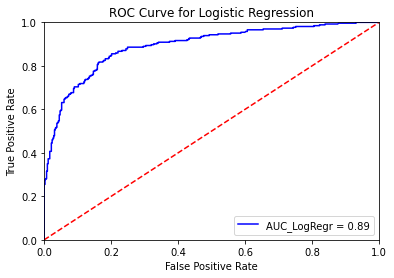

In [40]:
# ROC Curve and its AUC
Probs= clf.predict_proba(X_test)[:,1]
fpr_LogRegr, tpr_LogRegr, threshold = roc_curve(y_test, Probs)
roc_auc_LogRegr = auc(fpr_LogRegr, tpr_LogRegr)


plt.title('ROC Curve for Logistic Regression')
plt.plot(fpr_LogRegr, tpr_LogRegr, 'b', label = 'AUC_LogRegr = %0.2f' % roc_auc_LogRegr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### RandomForest

In [41]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators= 300)
clf = random_forest.fit(X_train, y_train.ravel())
Preds = clf.predict(X_test)
Score = clf.score(X_train, y_train)
print(Score)

scores = cross_val_score(clf,X_train,y_train.ravel(), scoring='roc_auc', cv=10)
np.mean(scores)

0.9875867104782767


0.8538164767497396

In [42]:
# Generate Confusion Matrix
confusion_matrix(y_test, Preds)

array([[367,  55],
       [ 70, 193]], dtype=int64)

In [43]:
# accuracy & precision
Accuracy = accuracy_score(y_test, Preds)
print(Accuracy)
Precision = precision_score(y_test, Preds, average= 'weighted')
print(Precision)

0.8175182481751825
0.8161695373608724


0.884656623357901


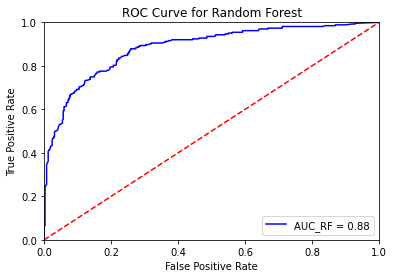

In [44]:
# ROC Curve and its AUC
Probs= clf.predict_proba(X_test)[:,1]
fpr_RF, tpr_RF, threshold = roc_curve(y_test, Probs)
roc_auc_RF = auc(fpr_RF, tpr_RF)
print(roc_auc_RF)

plt.title('ROC Curve for Random Forest')
plt.plot(fpr_RF, tpr_RF, 'b', label = 'AUC_RF = %0.2f' % roc_auc_RF)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


### Gradient Boosting Classifier

In [45]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
clf = GradientBoostingClassifier()
clf = clf.fit(X_train, y_train.ravel())
Preds = clf.predict(X_test)
Score = clf.score(X_train, y_train)
print(Score)

scores = cross_val_score(clf,X_train,y_train.ravel(), scoring='roc_auc', cv=10)
np.mean(scores)

0.8426433004746258


0.8722916130910434

In [46]:
# Generate Confusion Matrix
confusion_matrix(y_test, Preds)

array([[375,  47],
       [ 62, 201]], dtype=int64)

In [47]:
# accuracy & precision
Accuracy = accuracy_score(y_test, Preds)
print(Accuracy)
Precision = precision_score(y_test, Preds, average= 'weighted')
print(Precision)

0.8408759124087591
0.8398327073249713


0.9047492476528571


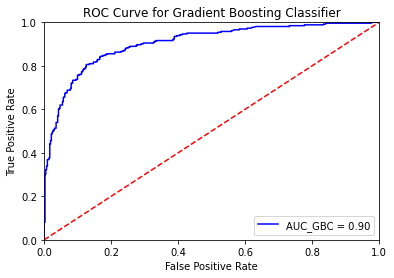

In [48]:
# ROC Curve and its AUC
Probs= clf.predict_proba(X_test)[:,1]
fpr_GBC, tpr_GBC, threshold = roc_curve(y_test, Probs)
roc_auc_GBC = auc(fpr_GBC, tpr_GBC)
print(roc_auc_GBC)
plt.title('ROC Curve for Gradient Boosting Classifier')
plt.plot(fpr_GBC, tpr_GBC, 'b', label = 'AUC_GBC = %0.2f' % roc_auc_GBC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Extra Trees Classifier

In [49]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier()
clf = clf.fit(X_train, y_train.ravel())
Preds = clf.predict(X_test)
Score = clf.score(X_train, y_train)
print(Score)

scores = cross_val_score(clf,X_train,y_train.ravel(), scoring='roc_auc', cv=10)
np.mean(scores)

0.9875867104782767


0.8354928230153448

In [50]:
# Generate Confusion Matrix
confusion_matrix(y_test, Preds)

array([[355,  67],
       [ 71, 192]], dtype=int64)

In [51]:
# accuracy & precision
Accuracy = accuracy_score(y_test, Preds)
print(Accuracy)
Precision = precision_score(y_test, Preds, average= 'weighted')
print(Precision)

0.7985401459854015
0.7980027994626535


0.8749391815183898


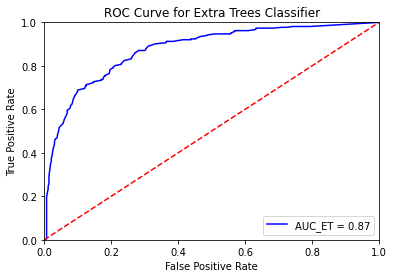

In [53]:
# ROC Curve and its AUC
Probs= clf.predict_proba(X_test)[:,1]
fpr_ET, tpr_ET, threshold = roc_curve(y_test, Probs)
roc_auc_ET = auc(fpr_ET, tpr_ET)
print(roc_auc_ET)
plt.title('ROC Curve for Extra Trees Classifier')
plt.plot(fpr_ET, tpr_ET, 'b', label = 'AUC_ET = %0.2f' % roc_auc_ET)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### K Nearest Neighbors Classifier

In [54]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 19)
clf = knn.fit(X_train,y_train.ravel())
Preds = clf.predict(X_test)
Score = clf.score(X_train, y_train)
print(Score)

scores = cross_val_score(clf,X_train,y_train.ravel(), scoring='roc_auc', cv=10)
np.mean(scores)

0.8039430449069004


0.8482867672657324

In [55]:
# Generate Confusion Matrix
confusion_matrix(y_test, Preds)

array([[386,  36],
       [ 92, 171]], dtype=int64)

In [56]:
# accuracy & precision
Accuracy = accuracy_score(y_test, Preds)
print(Accuracy)
Precision = precision_score(y_test, Preds, average= 'weighted')
print(Precision)

0.8131386861313868
0.8146556383110097


0.8818184275494206


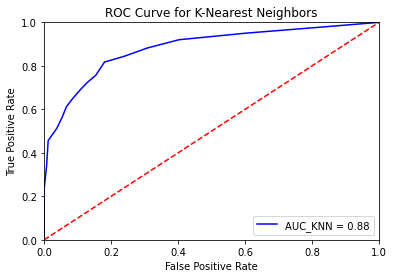

In [57]:
# ROC Curve and its AUC
Probs= clf.predict_proba(X_test)[:,1]
fpr_KNN, tpr_KNN, threshold = roc_curve(y_test, Probs)
roc_auc_KNN = auc(fpr_KNN, tpr_KNN)
print(roc_auc_KNN)
plt.title('ROC Curve for K-Nearest Neighbors')
plt.plot(fpr_KNN, tpr_KNN, 'b', label = 'AUC_KNN = %0.2f' % roc_auc_KNN)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Plot with all ROC curves and their respective AUCs

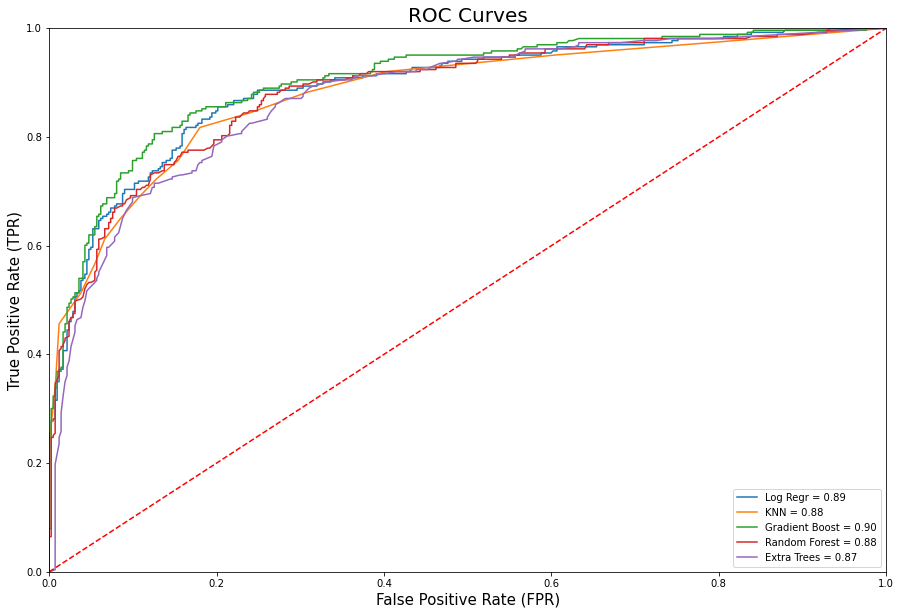

In [58]:
plt.figure(figsize = (15,10))
plt.title('ROC Curves', fontsize = 20)
plt.plot(fpr_LogR, tpr_LogR, label = 'Log Regr = %0.2f' % roc_auc_LogR)
plt.plot(fpr_KNN, tpr_KNN, label = 'KNN = %0.2f' % roc_auc_KNN)
plt.plot(fpr_GBC, tpr_GBC, label = 'Gradient Boost = %0.2f' % roc_auc_GBC)
plt.plot(fpr_RF, tpr_RF, label = 'Random Forest = %0.2f' % roc_auc_RF)
plt.plot(fpr_ET, tpr_ET, label = 'Extra Trees = %0.2f' % roc_auc_ET)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (TPR)', fontsize = 15)
plt.xlabel('False Positive Rate (FPR)', fontsize = 15)
plt.show()